# Introduction

This project analyzes data from online dating app OkCupid. These app give us access to a wealth of information that we've never had before about how different people experience romance.

The goal of this project is to try to predict some characteristics of the platform's users

# 0.0. Imports

In [1]:
# Relevant libraries

# Data manipulation
import numpy as np
import pandas as pd

# Warinig 
import warnings
warnings.filterwarnings('ignore')

# Load image
from IPython.display import Image

# Statistics
from scipy import stats

# Graphs
import matplotlib.pyplot as plt
import seaborn as sns

# Scalers
from sklearn.preprocessing import MinMaxScaler, LabelEncoder

# Feature selection
from boruta import BorutaPy

# Save files
import pickle

# Model selection
from sklearn.model_selection import train_test_split

# Machine Learning models
from sklearn.dummy import DummyClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier
from xgboost import XGBClassifier


# Model's cross-validation
from sklearn.model_selection import cross_validate, GridSearchCV

# Model's metrics
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, \
confusion_matrix, make_scorer

# Handling Oversampling
from imblearn.over_sampling import SMOTE

## 0.1. Helper Functions

In [ ]:
# Percentual plot function

def with_hue(plot, feature, Number_of_categories, hue_categories):
    a = [p.get_height() for p in plot.patches]
    patch = [p for p in plot.patches]
    for i in range(Number_of_categories):
        total = feature.value_counts().values[i]
        for j in range(hue_categories):
            percentage = '{:.1f}%'.format(100 * a[(j*Number_of_categories + i)]/total)
            x = patch[(j*Number_of_categories + i)].get_x() + patch[(j*Number_of_categories + i)].get_width() / 2 - 0.15
            y = patch[(j*Number_of_categories + i)].get_y() + patch[(j*Number_of_categories + i)].get_height() 
            ax.annotate(percentage, (x, y), size = 12)
    plt.show()

def without_hue(plot, feature):
    total = len(feature)
    for p in ax.patches:
        percentage = '{:.1f}%'.format(100 * p.get_height()/total)
        x = p.get_x() + p.get_width() / 2 - 0.05
        y = p.get_y() + p.get_height()
        ax.annotate(percentage, (x, y), size = 12)
    plt.show()

In [ ]:
# Calculate Cramers V statistic for categorial-categorial association.
def cramers_corrected_stat(x, y):
    # Calculate confusion matrix
    cm = pd.crosstab(x, y).values
    n = cm.sum()
    r, k = cm.shape

    # Calculate chi2
    chi2 = stats.chi2_contingency(cm)[0]
    # Calculate chi2 correction
    chi2corr = max(0, chi2 - (k-1)*(r-1)/(n-1))
    # K correction
    kcorr = k - (k-1)**2/(n-1)
    # R correction
    rcorr = r - (r-1)**2/(n-1)
    
    return np.sqrt((chi2corr/n) / (min(kcorr-1, rcorr-1)))

In [ ]:
# Label Enconder function
def label_classifier(var:str, dataset1: pd.DataFrame, dataset2: pd.DataFrame):
    dataset1[var] = le.fit_transform(dataset2[var])
    status_mappings = {index: label for index, label in 
                  enumerate(le.classes_)}
    return print(status_mappings)

In [ ]:
# Model's performance
def ml_scores(model_name, y_test, y_pred):
    
    accuracy = accuracy_score(y_test, y_pred)
    precision = precision_score(y_test, y_pred)
    recall = recall_score(y_test, y_pred)
    f1 = f1_score(y_test, y_pred)
    roc = roc_auc_score(y_test, y_pred)
    
    return pd.DataFrame({'Accuracy': accuracy, 
                         'Precision': precision, 
                         'Recall': recall,
                         'F1': f1,
                         'ROC': roc}, 
                        index=[model_name])

In [ ]:
# Confusion Matrix function
def conf_matrix(y_train, y_pred):
    cm = confusion_matrix(y_train, y_pred)
    cm_data = pd.DataFrame(cm, columns = ['Positive', 'Negative'], index=['Positive', 'Negative'])
    sns.heatmap(cm_data, annot=True, cmap='Blues', fmt='d', annot_kws={'size': 24}).set_title('Confusion Matrix')

    return plt.show()

In [ ]:
# Model's cross-validation performance 
def cross_val_performance(model, y_train, y_pred):
    # define scoring metrics
    scoring = {'Accuracy': 'accuracy',
               'Precision': make_scorer(precision_score),
               'Recall': make_scorer(recall_score),
               'F1': make_scorer(f1_score),
               'ROC': make_scorer(roc_auc_score)}

    # calculate scores with cross_validate
    scores = cross_validate(model, y_train, y_pred, cv=10, scoring=scoring)

    # performance data frame
    performance = pd.DataFrame.from_dict(scores).drop(['fit_time', 'score_time'], axis=1)
    performance = pd.DataFrame(np.round(performance.mean(), 4).astype(str) + '+/-' + np.round(performance.std()*2,4).astype(str)).T
    return performance

# 1.0. Data

## 1.1. Load the Data

In [2]:
# Importing dataset using pandas
df = pd.read_csv('profiles.csv')
df.head(3)

,age,body_type,diet,drinks,drugs,education,essay0,essay1,essay2,essay3,...,location,offspring,orientation,pets,religion,sex,sign,smokes,speaks,status
0,22,a little extra,strictly anything,socially,never,working on college/university,about me:<br />\n<br />\ni would love to think...,currently working as an international agent fo...,making people laugh.<br />\nranting about a go...,"the way i look. i am a six foot half asian, ha...",...,"south san francisco, california","doesn&rsquo;t have kids, but might want them",straight,likes dogs and likes cats,agnosticism and very serious about it,m,gemini,sometimes,english,single
1,35,average,mostly other,often,sometimes,working on space camp,i am a chef: this is what that means.<br />\n1...,dedicating everyday to being an unbelievable b...,being silly. having ridiculous amonts of fun w...,NaN,...,"oakland, california","doesn&rsquo;t have kids, but might want them",straight,likes dogs and likes cats,agnosticism but not too serious about it,m,cancer,no,"english (fluently), spanish (poorly), french (...",single
2,38,thin,anything,socially,NaN,graduated from masters program,"i'm not ashamed of much, but writing public te...","i make nerdy software for musicians, artists, ...",improvising in different contexts. alternating...,my large jaw and large glasses are the physica...,...,"san francisco, california",NaN,straight,has cats,NaN,m,pisces but it doesn&rsquo;t matter,no,"english, french, c++",available


## 1.2. Data Information

In [3]:
# Checking types and data structure
df.info(null_counts=True)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 59946 entries, 0 to 59945
Data columns (total 31 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   age          59946 non-null  int64  
 1   body_type    54650 non-null  object 
 2   diet         35551 non-null  object 
 3   drinks       56961 non-null  object 
 4   drugs        45866 non-null  object 
 5   education    53318 non-null  object 
 6   essay0       54458 non-null  object 
 7   essay1       52374 non-null  object 
 8   essay2       50308 non-null  object 
 9   essay3       48470 non-null  object 
 10  essay4       49409 non-null  object 
 11  essay5       49096 non-null  object 
 12  essay6       46175 non-null  object 
 13  essay7       47495 non-null  object 
 14  essay8       40721 non-null  object 
 15  essay9       47343 non-null  object 
 16  ethnicity    54266 non-null  object 
 17  height       59943 non-null  float64
 18  income       59946 non-null  int64  
 19  job 

* Dataset contain Null Values.
* dtypes: float64(1), int64(2), object(28)

## 1.3. Data Dimension

In [4]:
# Printing dataset shape
print(f'The shape of dataset: {df.shape}')

The shape of dataset: (59946, 31)


* Number of rows: 59946
* Number of columns: 31

## 1.4. Columns Description

In [5]:
# Show all columns
df.columns

Index(['age', 'body_type', 'diet', 'drinks', 'drugs', 'education', 'essay0',
       'essay1', 'essay2', 'essay3', 'essay4', 'essay5', 'essay6', 'essay7',
       'essay8', 'essay9', 'ethnicity', 'height', 'income', 'job',
       'last_online', 'location', 'offspring', 'orientation', 'pets',
       'religion', 'sex', 'sign', 'smokes', 'speaks', 'status'],
      dtype='object')

#### VARIABLE DESCRIPTIONS:
Missing data is blank. Some variables have two factors, which are denoted in this codebook by a semicolon (e.g. "graduated from; two-year college) though they are found without punctuation in the dataset. Details for specific variables are found in parenthesis.

#### Continuous variable
* **age**- User's Age
* **height**- inches
* **income**- (US $, -1 means rather not say) -1, 20000, 30000, 40000, 50000, 60000 70000, 80000, 100000, 150000, 250000, 500000, 1000000.

#### Categorical variable
- **body_type**- rather not say, thin, overweight, skinny, average, fit, athletic, jacked, a little extra, curvy, full figured, used up
- **diet**- mostly/strictly; anything, vegetarian, vegan, kosher, halal, other
- **drinks**- very often, often, socially, rarely, desperately, not at all
- **drugs**- never, sometimes, often
- **education**- graduated from, working on, dropped out of; high school, two-year college, university, masters program, law school, med school, Ph.D. program, space camp
- **ethnicity**- Asian, middle eastern, black, native American, Indian, pacific islander, Hispanic/Latin, white, other
- **job**- student, art/music/writing, banking/finance, administration, technology, construction, education, entertainment/media, management, hospitality, law, medicine, military, politics/government, sales/marketing, science/engineering, transportation, unemployed, other, rather not say, retire
- **offspring**- has a kid, has kids, doesn't have a kid, doesn't want kids; ,and/,but might want them, wants them, doesn't want any, doesn't want more
- **orientation**- straight, gay, bisexual
- **pets**- has dogs, likes dogs, dislikes dogs; and has cats, likes cats, dislikes cats
- **religion**- agnosticism, atheism, Christianity, Judaism, Catholicism, Islam, Hinduism, Buddhism, Other; and very serious about it, and somewhat serious about it, but not too serious about it, and laughing about it
- **sex**- m, f
- **sign**- aquarius, pices, aries, Taurus, Gemini, cancer, leo, virgo, libra, scorpio, saggitarius, Capricorn; but it doesn’t matter, and it matters a lot, and it’s fun to think about
- **smokes**- yes, sometimes, when drinking, trying to quit, no
- **speaks**- English (fluently, okay, poorly). Afrikaans, Albanian, Arabic, Armenian, Basque, Belarusan, Bengali, Breton, Bulgarian, Catalan, Cebuano, Chechen, Chinese, C++, Croatian, Czech, Danish, Dutch, Esperanto, Estonian, Farsi, Finnish, French, Frisian, Georgian, German, Greek, Gujarati, Ancient Greek, Hawaiian, Hebrew, Hindi, Hungarian, Icelandic, Ilongo, Indonesian, Irish, Italian, Japanese, Khmer, Korean, Latin, Latvian, LISP, Lithuanian, Malay, Maori, Mongolian, Norwegian, Occitan, Other, Persian, Polish, Portuguese, Romanian, Rotuman, Russian, Sanskrit, Sardinian, Serbian, Sign Language, Slovak, Slovenian, Spanish, Swahili, Swedish, Tagalog, Tamil, Thai, Tibetan, Turkish, Ukranian, Urdu, Vietnamese, Welsh, Yiddish (fluently, okay, poorly)

#### Date variable

* **last_online**- last login


#### Short answer
- **status**- single, seeing someone, married, in an open relationship
- **essay0**- My self summary
- **essay1**- What I’m doing with my life
- **essay2**- I’m really good at
- **essay3**- The first thing people usually notice about me
- **essay4**- Favorite books, movies, show, music, and food
- **essay5**- The six things I could never do without
- **essay6**- I spend a lot of time thinking about
- **essay7**- On a typical Friday night I am
- **essay8**- The most private thing I am willing to admit
- **essay9**- You should message me if...

#### **SPECIAL NOTES**
All essay questions are fill-in the blank, answers are not summarized here.

## 1.5. Null Values

In [6]:
# Count null values
df.isnull().sum()

age                0
body_type       5296
diet           24395
drinks          2985
drugs          14080
education       6628
essay0          5488
essay1          7572
essay2          9638
essay3         11476
essay4         10537
essay5         10850
essay6         13771
essay7         12451
essay8         19225
essay9         12603
ethnicity       5680
height             3
income             0
job             8198
last_online        0
location           0
offspring      35561
orientation        0
pets           19921
religion       20226
sex                0
sign           11056
smokes          5512
speaks            50
status             0
dtype: int64

In [7]:
no_null_values = df.dropna()
print(f'The shape of the regular dataset is: {df.shape}')
print(f'The shape of dataset without null values is: {no_null_values.shape}')

The shape of the regular dataset is: (59946, 31)
The shape of dataset without null values is: (4407, 31)


* There is a lot Null Values, we are dealing with them later.
* Removing all Null Values results in a great loss.

## 1.6. Descriptive Statistics

### 1.6.1. Numerical attributes

In [8]:
# Select numerical attributes
num_attr = df.select_dtypes(exclude='object')

# Describe
describe = num_attr.describe().T

describe['range'] = (num_attr.max() - num_attr.min()).tolist()
describe['unique val.'] = num_attr.nunique()
describe['variation coefficient'] = np.round((num_attr.std() / num_attr.mean()), 4).tolist()
describe['skew'] = np.round(num_attr.skew(), 4).tolist()
describe['kurtosis'] = np.round(num_attr.kurtosis(), 4).tolist()

describe

,count,mean,std,min,25%,50%,75%,max,range,unique val.,variation coefficient,skew,kurtosis
age,59946.0,32.340290,9.452779,18.0,26.0,30.0,37.0,110.0,92.0,54,0.2923,1.2658,1.5725
height,59943.0,68.295281,3.994803,1.0,66.0,68.0,71.0,95.0,94.0,60,0.0585,-0.4631,7.7611
income,59946.0,20033.222534,97346.192104,-1.0,-1.0,-1.0,-1.0,1000000.0,1000001.0,13,4.8592,9.0362,86.8702


* age and income are high skewed.
* income -1 values are Null Values.

### 1.6.2. Categorical attributes

In [9]:
# Select categorical attributes
cat_attr = df.select_dtypes(include='object')

# Describe
cat_attr.describe().drop('top').T

,count,unique,freq
body_type,54650,12,14652
diet,35551,18,16585
drinks,56961,6,41780
drugs,45866,3,37724
education,53318,32,23959
essay0,54458,54350,12
essay1,52374,51516,61
essay2,50308,48635,82
essay3,48470,43533,529
essay4,49409,49260,16


* essay features are mostly unique answers

### 1.6.3. Target variable attributes

In [10]:
df.status.value_counts()

single            55697
seeing someone     2064
available          1865
married             310
unknown              10
Name: status, dtype: int64

We are targeting on relashionship users and single. 
User without relashionship are:
* single and available

# 2.0. Feature Engineering

In [11]:
# Creating a new dataset
df2 = df.copy()

# List of drop columns
essay_list = ['essay0', 'essay1', 'essay2', 'essay3',
              'essay4', 'essay5', 'essay6', 'essay7', 
              'essay8', 'essay9']

# Drop columns
df2 = df2.drop(essay_list, axis = 1)

In [12]:
print(df2.columns)
df2.head(2)

Index(['age', 'body_type', 'diet', 'drinks', 'drugs', 'education', 'ethnicity',
       'height', 'income', 'job', 'last_online', 'location', 'offspring',
       'orientation', 'pets', 'religion', 'sex', 'sign', 'smokes', 'speaks',
       'status'],
      dtype='object')


,age,body_type,diet,drinks,drugs,education,ethnicity,height,income,job,...,location,offspring,orientation,pets,religion,sex,sign,smokes,speaks,status
0,22,a little extra,strictly anything,socially,never,working on college/university,"asian, white",75.0,-1,transportation,...,"south san francisco, california","doesn&rsquo;t have kids, but might want them",straight,likes dogs and likes cats,agnosticism and very serious about it,m,gemini,sometimes,english,single
1,35,average,mostly other,often,sometimes,working on space camp,white,70.0,80000,hospitality / travel,...,"oakland, california","doesn&rsquo;t have kids, but might want them",straight,likes dogs and likes cats,agnosticism but not too serious about it,m,cancer,no,"english (fluently), spanish (poorly), french (...",single


In [14]:
# Create date time column
df2['last_datetime'] = df2.last_online.str.replace(r'\D', repl ='', regex=True)
df2.last_datetime = pd.to_datetime(df2.last_datetime, format = '%Y%m%d%H%M')

# Spliting columns into hour and date
df2['hour'] = pd.to_datetime(df2.last_datetime).dt.time
df2['date'] = pd.to_datetime(df2.last_datetime).dt.date

In [15]:
# Age range column
df2['age_range'] = df2.age.apply(lambda x: 'young adult' if 18 <= x <= 35 else ('adult' if 36 <= x <= 55 else 'Senior'))

In [16]:
# Diet column
df2['new_diet'] = df2.diet.str.split().str.get(-1)

In [17]:
# More than 1 job
df2['multi_tasks'] = df2.job.apply(lambda x: True if len(str(x).split()) > 1 else False)

# Putting long descriptions in the 'other' category
df2.ethnicity = df2.ethnicity.apply(lambda x: 'latin' if x == 'hispanic / latin' else x)
df2['new_ethnicity'] = df2.ethnicity.apply(lambda x: 'other' if len(str(x).split()) > 1 else x)

In [18]:
# Classify education column with student, work or dropped
df2.education = df2.education.str.replace(r'[^\w]\S+', regex=True, repl='')
df2['new_education'] = df2.education.apply(lambda x: 'working' if x == 'working'\
        else ('drop' if x == 'dropped' else 'study'))

In [19]:
# Setting state location
df2['state'] = df2.location.str.split().str.get(-1)

# Setting religion affinity
df2['religion_affinity'] = df2.religion.str.split().str.get(0)

# User sign
df2['new_sign'] = df2.sign.str.split().str.get(0)

# Setting Job
df2['new_jobs'] = df2.job.str.split().str.get(0)

# 3.0. Hypotheses Creation

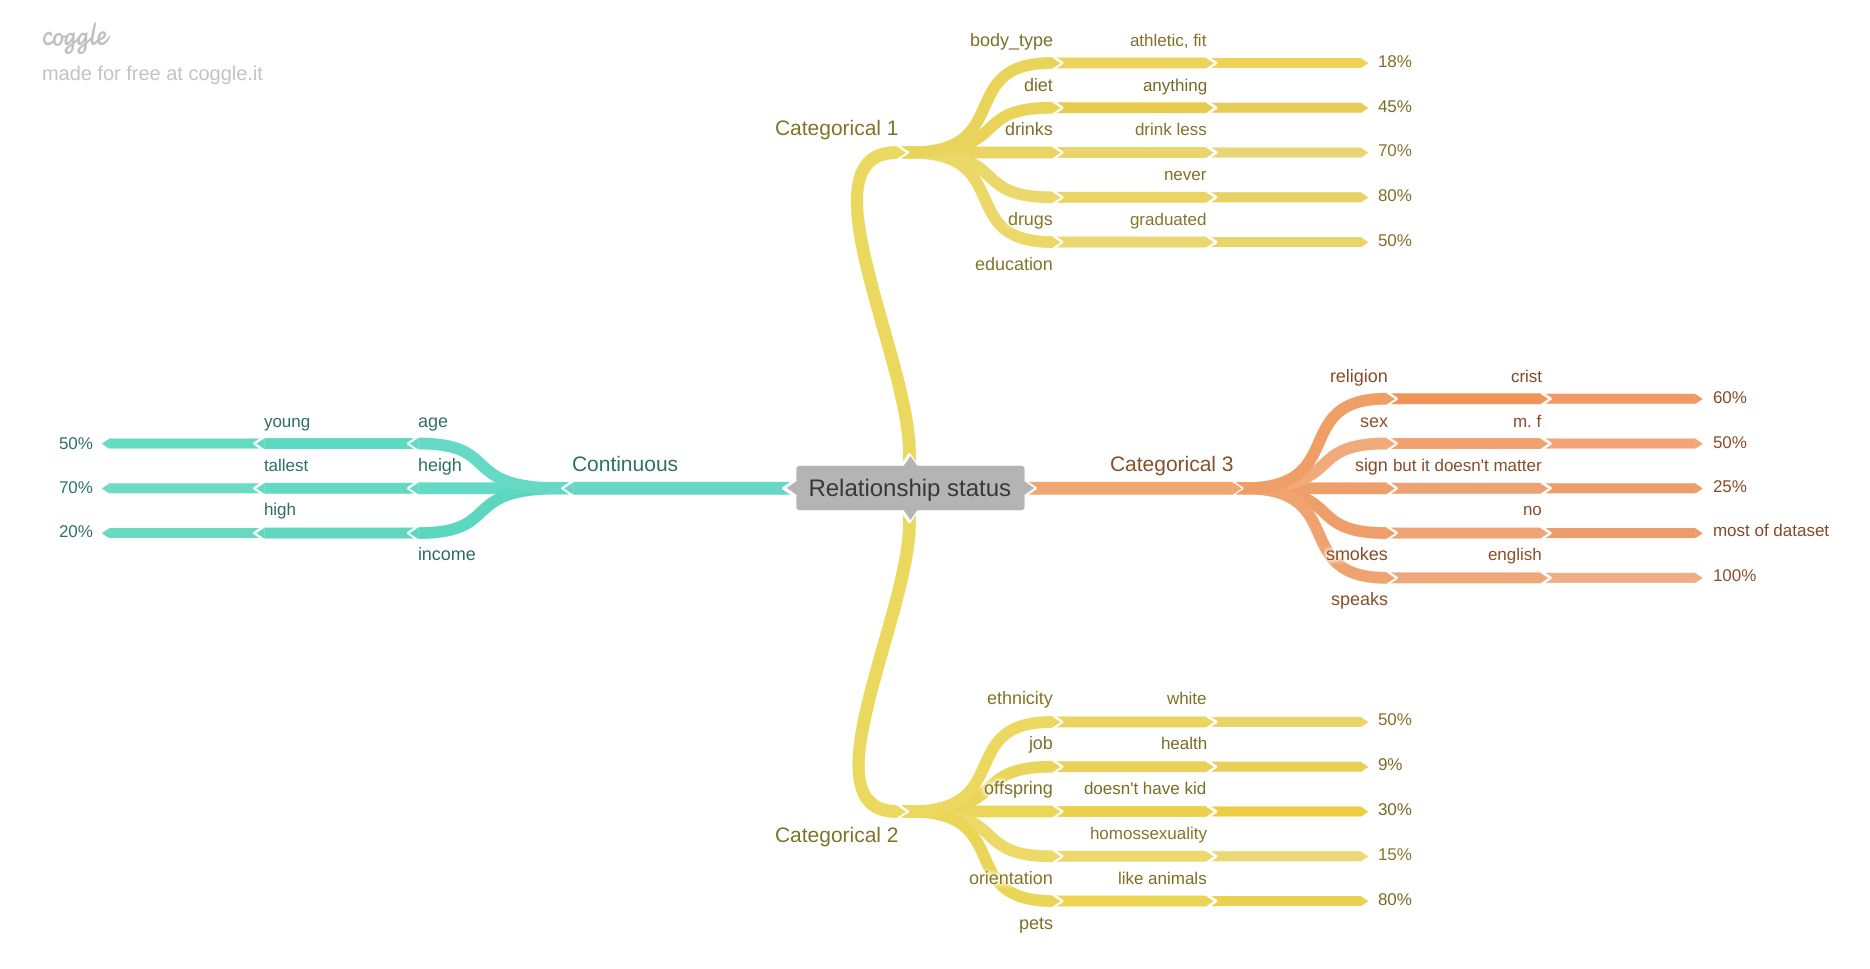

In [21]:
Image('img/Relationship_status.png') # Some feature names need correction

## 3.1. Continuous

* H1. Young users represent 50% or more of people in a relationship.
* H2. The bigger the person the greater the chances of being in a relationship.
* H3. The bigger the income the greater the chances of being in a relationship.

## 3.2. Categorical 1

* H1. Athletic and fit user represent 20% of the total users in relationship status.
* H2. Student user represent 50% of the total user in a relationship status.
* H3. People who drink less represent 70% of the total user in a relationship status.

## 3.3. Categorical 2

* H1. Males and females are represented in a balanced way.
* H2. 20% of the total user don't care about sign.
* H3. Black people represent 30% of the total user in a relationship status.

## 3.4. Categorical 3

* H1. 10% of user works in health field.

## 3.5. Summary

| ID   | HYPOTHESES                                                   |
| ---- | ------------------------------------------------------------ |
| H1   | Athletic and fit user represent 20% of the total users in relationship status. |
| H2   | Student user represent 50% of the total user in a relationship status. |
| H3   | People who drink less represent 70% of the total user in a relationship status. |
| H4   | Males and females are represented in a balanced way.         |
| H5   | 20% of the total user don't care about sign.                 |
| H6   | Black people represent 30% of the total user in a relationship status. |
| H7   | 10% of user works in health field.                           |
| H8   | 50% of the total user are straight.                          |

In [22]:
# Saving dataset
df2.to_csv('dataset/df2.csv', index=False)

# 4.0. Exploratory Data Analysis

In [4]:
# Load data
df3 = pd.read_csv('dataset/df2.csv')

In [5]:
# Drop columns
df3 = df3.drop([
    'diet', 'education', 'ethnicity', 
    'job', 'last_online', 'location',
    'last_datetime', 'religion',
    'hour', 'date', 'speaks'], axis=1)

## 4.1. Univariate Analysis

### 4.1.1. Target variable

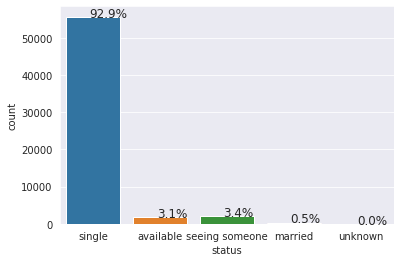

In [6]:
# Setting plot style
sns.set_style('darkgrid')

# Ploting target variable
ax = sns.countplot(x='status', data=df3)
without_hue(ax, df3.status)

* The target variable is imbalanced.
* Single and available represent the same target, single user.

### 4.1.2. Numerical variables distribution

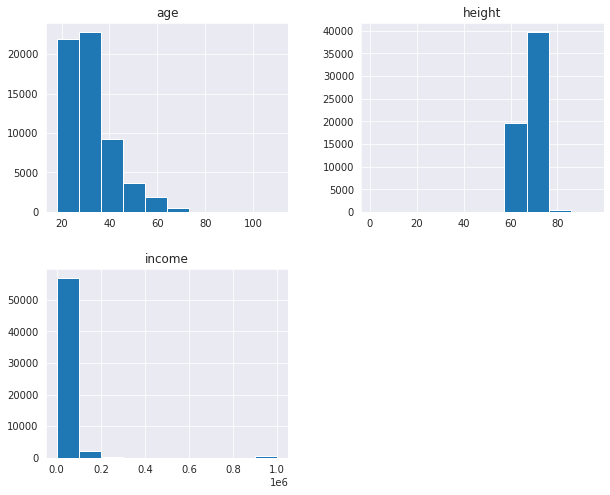

In [7]:
# Selecting numerical features
numerical_df3 = df3.select_dtypes(exclude='object')

# Plot numerical features
numerical_df3.hist(figsize=(10,8))
plt.show()

### 4.1.3. Categorical variable

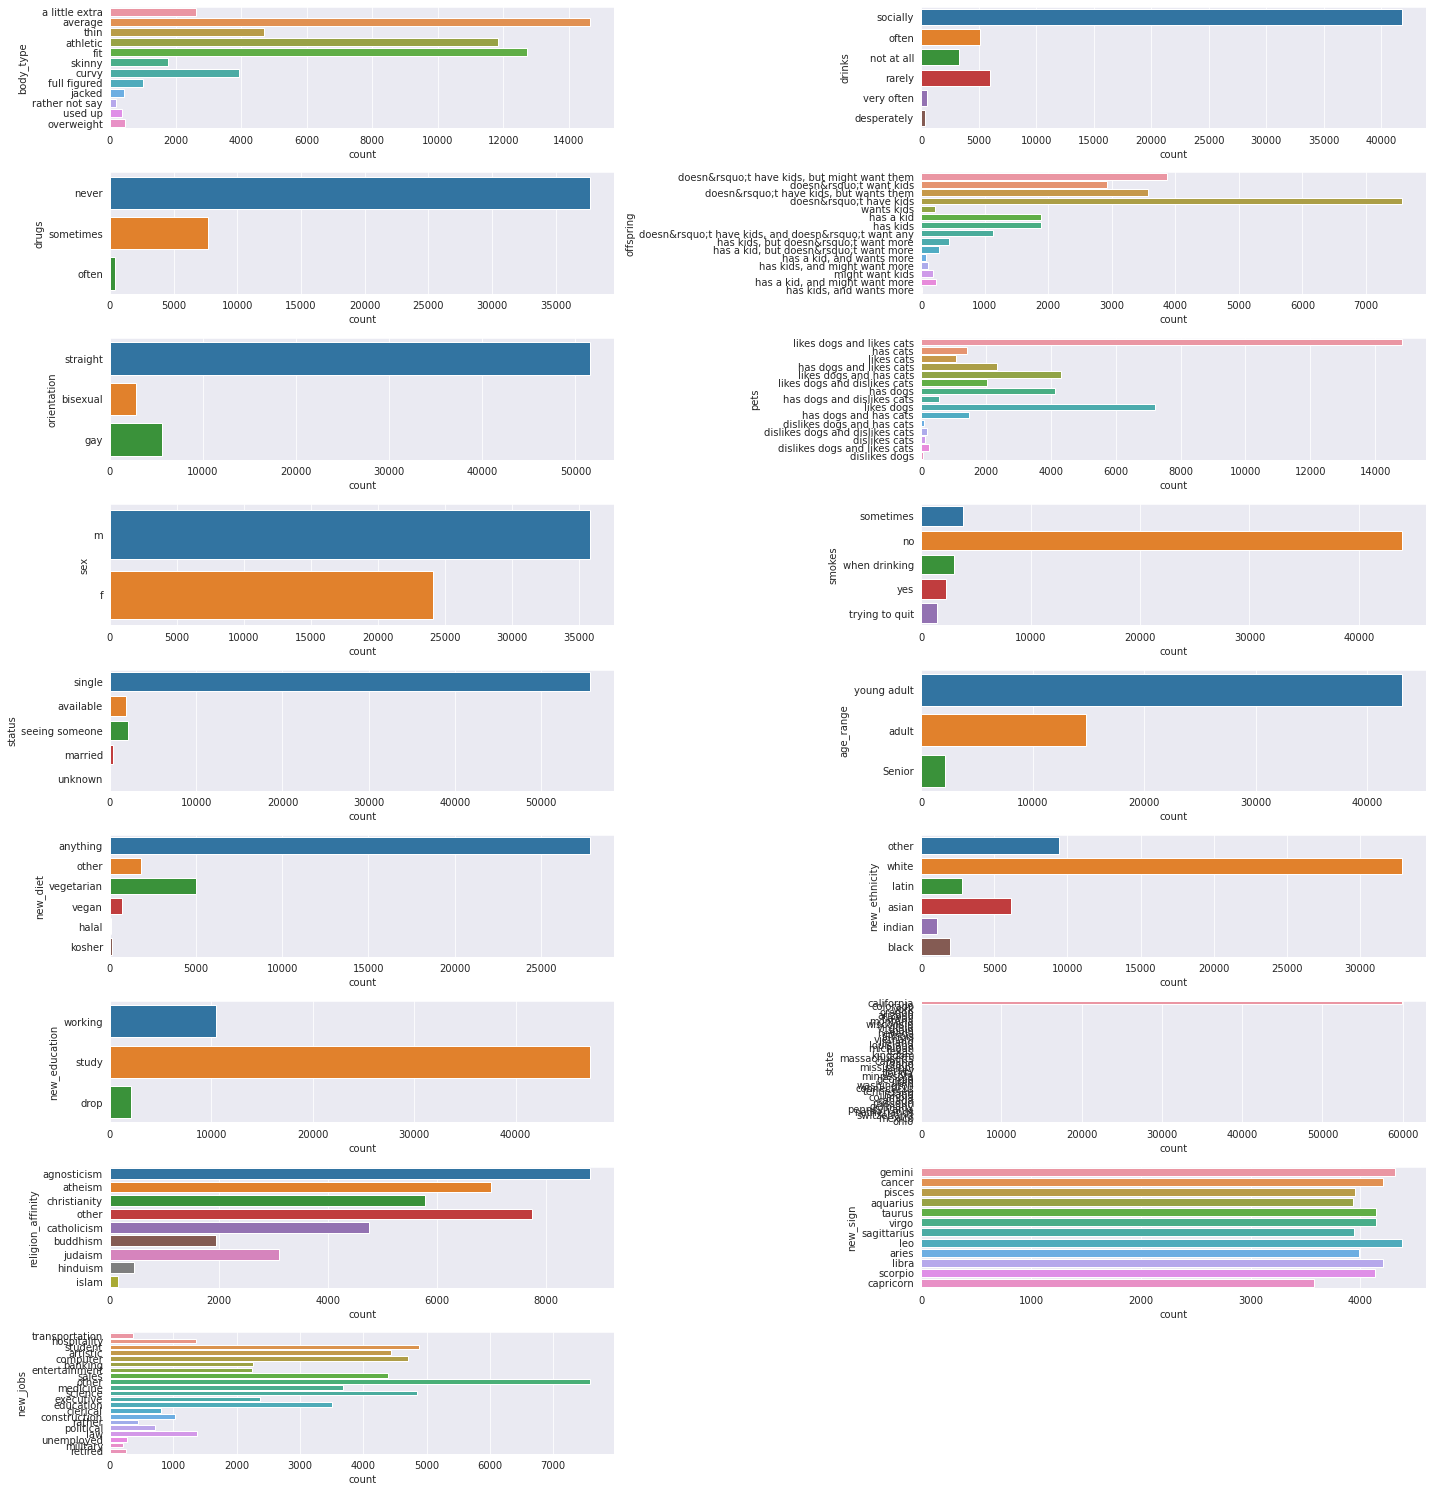

In [30]:
# Selecting categorical columns
categorical_df3 = df3.select_dtypes(include='object').drop('sign', axis=1)

# Adjust figsize
plt.figure(figsize=(20,25))

# Loop the categorical plot
for i in range(len(categorical_df3.columns)):
    plt.subplot(11, 2, i+1)
    ax = sns.countplot(y=categorical_df3[categorical_df3.columns[i]])
    plt.tight_layout()

# Display subplots
plt.show()

## 4.2 Bivariate Analysis

In [9]:
# Couple users
couple = df3[(df3.status == 'seeing someone') | (df3.status == 'married')]

### H1 Athletic and fit user represent 20% of the total users in relationship status.
**TRUE**: Athletic and fit users represents 24.5% of the total user.

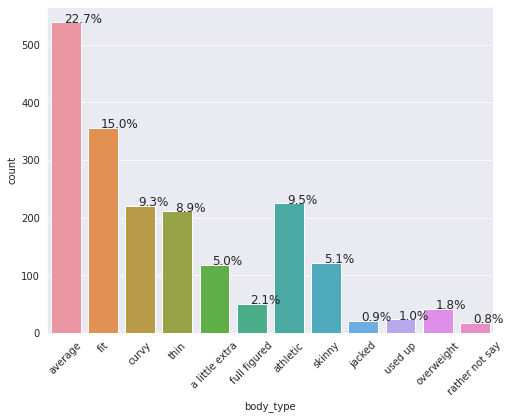

In [10]:
# Plot percentual
plt.figure(figsize=(8,6))
ax = sns.countplot(x='body_type', data=couple)
plt.xticks(rotation=45)
without_hue(ax, couple.body_type)
plt.show()

 ### H2	Student user represent 50% of the total user in a relationship status.
 **TRUE**: Students represents 70% of users with a relationship.

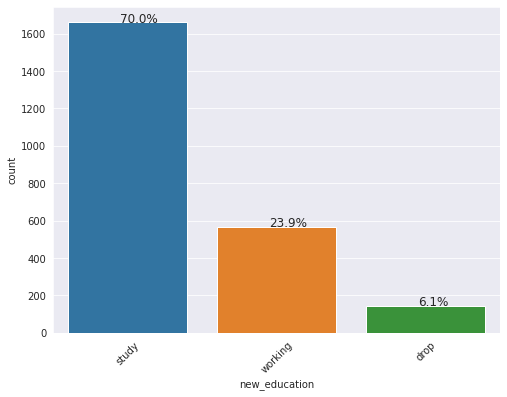

In [11]:
plt.figure(figsize=(8,6))
ax = sns.countplot(x='new_education', data=couple)
plt.xticks(rotation=45)
without_hue(ax, couple.new_education)
plt.show()

### H3	People who drink less represent 70% of the total user in a relationship status.
**TRUE**: People who drinks less represent 83% of user with a relationship.

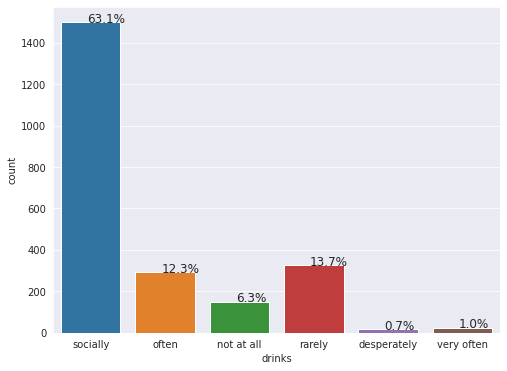

In [12]:
plt.figure(figsize=(8,6))
ax = sns.countplot(x='drinks', data=couple)
without_hue(ax, couple.drinks)
plt.show()

### H4	Males and females are represented in a balanced way.
**TRUE**: Males and females with relationship are balanced.

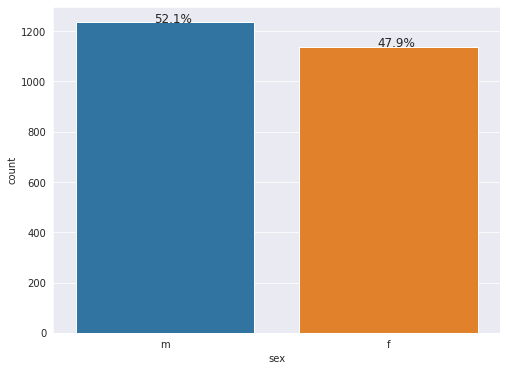

In [13]:
plt.figure(figsize=(8,6))
ax = sns.countplot(x='sex', data=couple)
without_hue(ax, couple.sex)
plt.show()

### H5	20% of the total user don't care about sign.
**TRUE**: 30.9% of the total user in relationship do not care about signs.

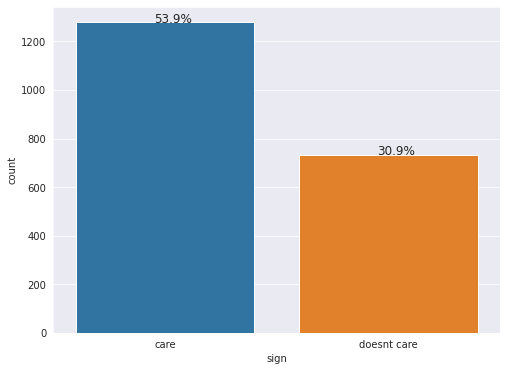

In [14]:
doenst = couple.sign.str.contains('doesn&rsquo;t')

plt.figure(figsize=(8,6))
ax = sns.countplot(doenst)
plt.xticks([0,1],['care', 'doesnt care'])
without_hue(ax, doenst)

plt.show()

### H6	Black people represent 30% of the total user in a relationship status.
**FALSE**: Black people represents 1.6% of the total users in a relationship.

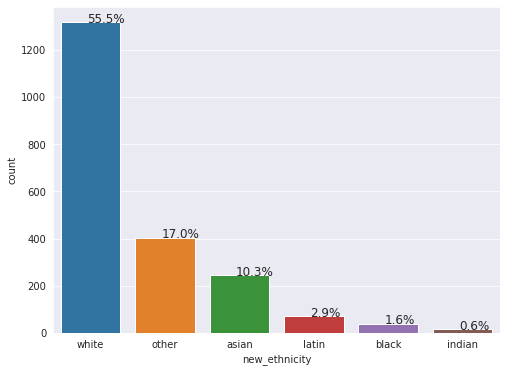

In [15]:
plt.figure(figsize=(8,6))
ax = sns.countplot(x='new_ethnicity', data=couple)
without_hue(ax, couple.new_ethnicity)
plt.show()

### H7	10% of user works in health field.
**FALSE**: Users who work in health field represents 4.4% of users with relationship.

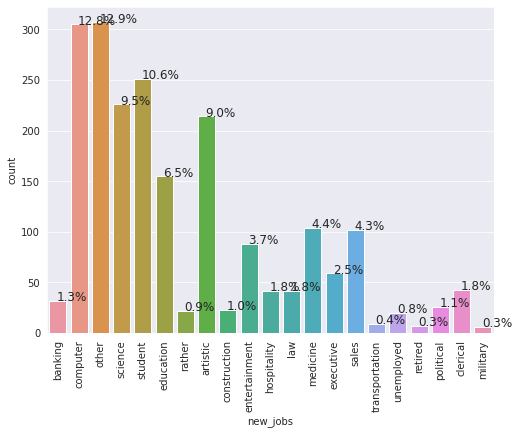

In [16]:
plt.figure(figsize=(8,6))
ax = sns.countplot(x='new_jobs', data=couple)
plt.xticks(rotation=90)
without_hue(ax, couple.new_jobs)
plt.show()

### H8	50% of the total user are straight.
**TRUE**: 72.2% f users who are in a relationship consider themselves straight. 

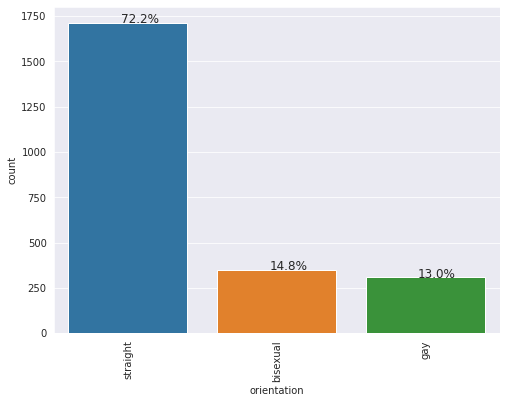

In [17]:
plt.figure(figsize=(8,6))
ax = sns.countplot(x='orientation', data=couple)
plt.xticks(rotation=90)
without_hue(ax, couple.orientation)
plt.show()

## 4.3. Multivariate Analysis

### 4.3.1. Numerical variables

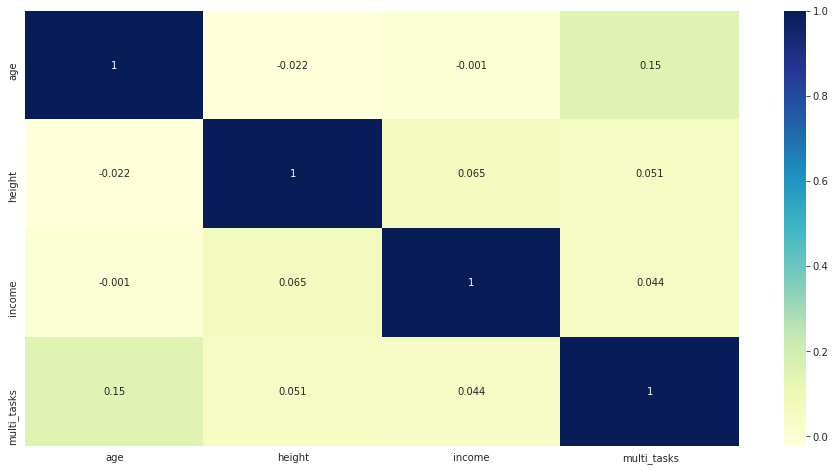

In [18]:
plt.figure(figsize=(16,8))
sns.heatmap(numerical_df3.corr(), annot=True, cmap='YlGnBu')
plt.show()

### 4.3.2. Categorical variables

In [19]:
cat_attributes = df3.select_dtypes(include='object')

dict_for_corr = {}
columns = cat_attributes.columns.tolist()

for column in columns:
    dict_for_corr[column] = {}

    for column2 in columns:
        dict_for_corr[column][column2] = cramers_corrected_stat(cat_attributes[column], cat_attributes[column2])

corr_cat = pd.DataFrame(dict_for_corr)

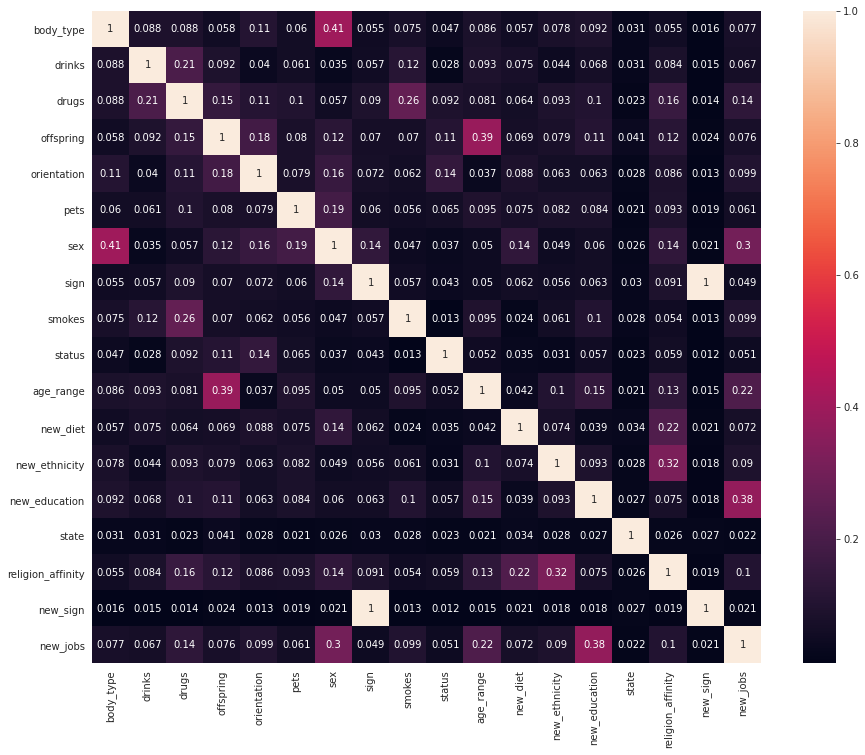

In [20]:
plt.figure(figsize=(15,12))
sns.heatmap(corr_cat, annot=True)
plt.show()

# 5.0. Data Preparation

In [3]:
# Load data
df4 = pd.read_csv('dataset/df2.csv')

In [4]:
# Removing cols
df4 = df4.drop([
    'diet', 'education', 'ethnicity', 
    'job', 'last_online', 'location',
    'last_datetime','religion', 'sign',
    'speaks', 'multi_tasks'], axis=1)

## 5.1. Missing Values

Droping: 
* `offspring` column, approximately 60% of its entries are missing values.
* `income` column, 80% of its entries are missing values.
* `new_diet` column 40% is missing values.
* `religion_affinity` column has 33% of missing values.

In [5]:
# Transforming target variable
unknown = {
    'single' : 'single',
    'available' : 'single',
    'seeing someone' : 'couple',
    'married' : 'couple',
    'unknown' : np.nan
}
df4.status = df4.status.map(unknown)

In [6]:
df4.isnull().sum()

age                      0
body_type             5296
drinks                2985
drugs                14080
height                   3
income                   0
offspring            35561
orientation              0
pets                 19921
sex                      0
smokes                5512
status                  10
hour                     0
date                     0
age_range                0
new_diet             24395
new_ethnicity         5680
new_education            0
state                    0
religion_affinity    20226
new_sign             11056
new_jobs              8198
dtype: int64

In [7]:
# Droping offspring, income, new diet and religion affinity
df4 = df4.drop(['offspring', 'income', 'new_diet', 'religion_affinity'], axis=1)

In [8]:
df4 = df4.dropna()
df4.shape

(21827, 18)

## 5.2 Transformation

In [9]:
# Dataset copy
df5 = df4.copy()

In [10]:
# Hour and date intod daytime
df5.hour = pd.to_datetime(df5['hour']).dt.hour
df5.date = df5['date'].astype('datetime64[ns]')

In [12]:
# Transforming attributes
le = LabelEncoder()

# Selecting columns for label encoder:
col = df5.select_dtypes(include='object')

# Target variable, checking subsection 0.1. Helper Function
for i in col: 
    label_classifier(i, df5, df4)

{0: 'a little extra', 1: 'athletic', 2: 'average', 3: 'curvy', 4: 'fit', 5: 'full figured', 6: 'jacked', 7: 'overweight', 8: 'rather not say', 9: 'skinny', 10: 'thin', 11: 'used up'}
{0: 'desperately', 1: 'not at all', 2: 'often', 3: 'rarely', 4: 'socially', 5: 'very often'}
{0: 'never', 1: 'often', 2: 'sometimes'}
{0: 'bisexual', 1: 'gay', 2: 'straight'}
{0: 'dislikes cats', 1: 'dislikes dogs', 2: 'dislikes dogs and dislikes cats', 3: 'dislikes dogs and has cats', 4: 'dislikes dogs and likes cats', 5: 'has cats', 6: 'has dogs', 7: 'has dogs and dislikes cats', 8: 'has dogs and has cats', 9: 'has dogs and likes cats', 10: 'likes cats', 11: 'likes dogs', 12: 'likes dogs and dislikes cats', 13: 'likes dogs and has cats', 14: 'likes dogs and likes cats'}
{0: 'f', 1: 'm'}
{0: 'no', 1: 'sometimes', 2: 'trying to quit', 3: 'when drinking', 4: 'yes'}
{0: 'couple', 1: 'single'}
{0: 'Senior', 1: 'adult', 2: 'young adult'}
{0: 'asian', 1: 'black', 2: 'indian', 3: 'latin', 4: 'other', 5: 'white'}

## 5.3. Rescaling

In [13]:
# Call function
mms = MinMaxScaler()

# Selecting numerical columns
cols_n = df5.select_dtypes(exclude='object').columns

# Loop rescaling
for i in cols_n:
    df5[i] = mms.fit_transform(df5[[i]].values)

In [14]:
df5.to_csv('dataset/df5.csv', index=False)

# 6.0. Feature Selection

In [2]:
# Load data
df5 = pd.read_csv('dataset/df5.csv')

## 6.1. Drop and Split Columns

In [5]:
# Variables
X_feature = df5.drop('status', axis=1)

# Target variable
Y_feature = df5.status

## 6.2. Feature Importance

[0.10800571 0.07173193 0.040542   0.01985817 0.10218102 0.02640199
 0.06751544 0.01855343 0.0283014  0.1079752  0.14859816 0.00853645
 0.03817405 0.02803215 0.00086715 0.09385625 0.09086949]


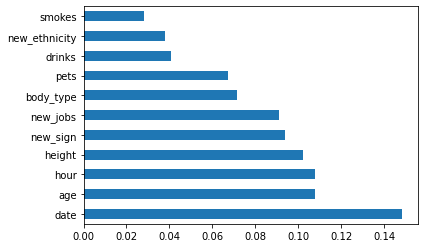

In [6]:
# Selecting Model
model = RandomForestClassifier()
model.fit(X_feature, Y_feature)

# Use inbuilt class feature_importances of tree based classifiers
print(model.feature_importances_)
 
# Plot graph of feature importances for better visualization
feat_importances = pd.Series(model.feature_importances_, index=X_feature.columns)
feat_importances.nlargest(11).plot(kind='barh')
plt.show()

## 6.3. Boruta

In [7]:
# Train using random forest classifier

# X train
X_boruta = X_feature.values

# Y train
Y_boruta = Y_feature.values

# Define random forest classifier
rf = RandomForestClassifier(n_estimators=200, n_jobs=4, max_depth = 6, class_weight='balanced')

# Define Boruta feature selection method
feat_selector = BorutaPy(rf, n_estimators='auto', verbose=2, random_state=42).fit(X_boruta, Y_boruta)

Iteration: 	1 / 100
Confirmed: 	0
Tentative: 	17
Rejected: 	0
Iteration: 	2 / 100
Confirmed: 	0
Tentative: 	17
Rejected: 	0
Iteration: 	3 / 100
Confirmed: 	0
Tentative: 	17
Rejected: 	0
Iteration: 	4 / 100
Confirmed: 	0
Tentative: 	17
Rejected: 	0
Iteration: 	5 / 100
Confirmed: 	0
Tentative: 	17
Rejected: 	0
Iteration: 	6 / 100
Confirmed: 	0
Tentative: 	17
Rejected: 	0
Iteration: 	7 / 100
Confirmed: 	0
Tentative: 	17
Rejected: 	0
Iteration: 	8 / 100
Confirmed: 	6
Tentative: 	4
Rejected: 	7
Iteration: 	9 / 100
Confirmed: 	6
Tentative: 	4
Rejected: 	7
Iteration: 	10 / 100
Confirmed: 	6
Tentative: 	4
Rejected: 	7
Iteration: 	11 / 100
Confirmed: 	6
Tentative: 	4
Rejected: 	7
Iteration: 	12 / 100
Confirmed: 	7
Tentative: 	2
Rejected: 	8
Iteration: 	13 / 100
Confirmed: 	7
Tentative: 	2
Rejected: 	8
Iteration: 	14 / 100
Confirmed: 	7
Tentative: 	2
Rejected: 	8
Iteration: 	15 / 100
Confirmed: 	7
Tentative: 	2
Rejected: 	8
Iteration: 	16 / 100
Confirmed: 	7
Tentative: 	2
Rejected: 	8
Iteration:

In [9]:
# Check selected features
cols_selected_boruta = feat_selector.support_.tolist()
columns_selected = df5.drop(['status'], axis=1).loc[:, cols_selected_boruta].columns.tolist()
columns_selected

['age',
 'body_type',
 'drugs',
 'height',
 'orientation',
 'pets',
 'date',
 'age_range',
 'new_jobs']

# 7.0. Machine Learning

In [5]:
# Load data
df5 = pd.read_csv('dataset/df5.csv')

In [6]:
boruta_select = ['age',
 'body_type',
 'drugs',
 'height',
 'orientation',
 'pets',
 'date',
 'age_range',
 'new_jobs']

## 7.1. Spliting Into Train, Valid and Test

In [7]:
# New dataset for machine learning
df6 = df5.copy()

# Variables
X = df6[boruta_select]

# Target variable
Y = df6.status

# Spliting
x_train, x_test, y_train, y_test = train_test_split(X, Y, test_size = 0.2, random_state = 47)

In [8]:
# Since Data Set is imbalanced, SMOTE will apply_train to balance representatoin of Response feature
print("Shape of x_train before over-Sampling:", x_train.shape)
print("Shape of y_train before over-Sampling:", y_train.shape)
print("---" * 15)
print('Proportion of target variable before over-Sampling:')
print(y_train.value_counts())

# SMOTE
oversample = SMOTE()
x_train, y_train = oversample.fit_resample(x_train, y_train)

print("Shape of x_train after over-Sampling:", x_train.shape)
print("Shape of y_train after over-Sampling:", y_train.shape)
print("---" * 15)
print('Proportion of target variable after over-Sampling:')
print(y_train.value_counts())

Shape of x_train before over-Sampling: (17461, 9)
Shape of y_train before over-Sampling: (17461,)
---------------------------------------------
Proportion of target variable before over-Sampling:
1.0    16732
0.0      729
Name: status, dtype: int64
Shape of x_train after over-Sampling: (33464, 9)
Shape of y_train after over-Sampling: (33464,)
---------------------------------------------
Proportion of target variable after over-Sampling:
0.0    16732
1.0    16732
Name: status, dtype: int64


## 7.2. Baseline: Dummy Classifier

In [9]:
# Model and fit
dummy = DummyClassifier().fit(x_train, y_train)

# Predicting
y_pred = dummy.predict(x_test)

### 7.2.1. Baseline performance

In [10]:
Dummy_performance = ml_scores('Baseline', y_test, y_pred)
Dummy_performance

,Accuracy,Precision,Recall,F1,ROC
Baseline,0.044663,0.0,0.0,0.0,0.5


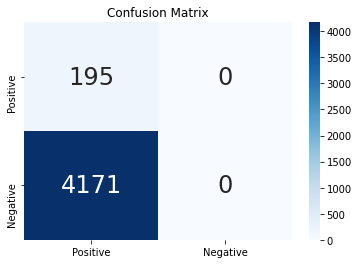

In [11]:
conf_matrix(y_test, y_pred)

## 7.3. K-Neighbors Classifier

In [13]:
# Model and fit
kn = KNeighborsClassifier().fit(x_train, y_train)

# Predicting
y_pred_kn = kn.predict(x_test)

### 7.3.1. K-Neighbors performance

In [14]:
performance_kn = ml_scores('K-Neighbors', y_test, y_pred_kn)
performance_kn

,Accuracy,Precision,Recall,F1,ROC
K-Neighbors,0.791113,0.961223,0.814193,0.88162,0.555815


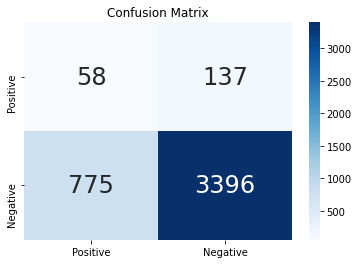

In [17]:
conf_matrix(y_test, y_pred_kn)

## 7.4. Random Forest Classifier

In [18]:
# Model and fit
rfc = RandomForestClassifier().fit(x_train, y_train)

# Predicting
y_pred_rfc = rfc.predict(x_test)

### 7.4.1. Random Forest Classifier performance

In [19]:
rfc_performance = ml_scores('Random Forest', y_test, y_pred_rfc)
rfc_performance

,Accuracy,Precision,Recall,F1,ROC
Random Forest,0.943885,0.955664,0.987053,0.971105,0.503783


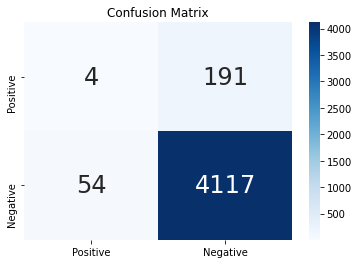

In [20]:
conf_matrix(y_test, y_pred_rfc)

## 7.5. XGBoost Classifier

In [21]:
# Model and fit
xgb = XGBClassifier().fit(x_train, y_train)

# Predicting
y_pred_xgb = xgb.predict(x_test)

[10:04:12] WARNING: ../src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


### 7.5.1. XGBoost Classifier performance

In [22]:
xgb_performance = ml_scores('XGBoost Classifier', y_test, y_pred_xgb)
xgb_performance

,Accuracy,Precision,Recall,F1,ROC
XGBoost Classifier,0.953733,0.955683,0.997842,0.976308,0.504049


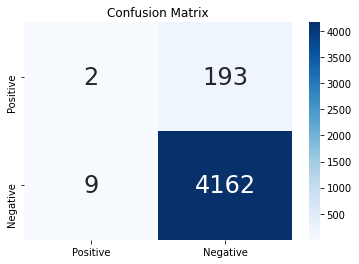

In [23]:
conf_matrix(y_test, y_pred_xgb)

## 7.6. Results

In [24]:
performance = pd.concat([Dummy_performance, performance_kn, rfc_performance, xgb_performance])
performance

,Accuracy,Precision,Recall,F1,ROC
Baseline,0.044663,0.000000,0.000000,0.000000,0.500000
K-Neighbors,0.791113,0.961223,0.814193,0.881620,0.555815
Random Forest,0.943885,0.955664,0.987053,0.971105,0.503783
XGBoost Classifier,0.953733,0.955683,0.997842,0.976308,0.504049


# 8.0. Cross Validation

## 8.1. K-Neighbors

In [35]:
kn_cv = cross_val_performance(kn, x_train, y_train)
kn_cv

,test_Accuracy,test_Precision,test_Recall,test_F1,test_ROC
0,0.9008+/-0.0089,0.9845+/-0.0081,0.8144+/-0.0162,0.8914+/-0.0104,0.9008+/-0.0089


## 8.2. Random Forest Classifier

In [31]:
rfc_cv = cross_val_performance(rfc, x_train, y_train)
rfc_cv

,test_Accuracy,test_Precision,test_Recall,test_F1,test_ROC
0,0.9774+/-0.0869,0.9749+/-0.1389,0.9861+/-0.0067,0.9792+/-0.0756,0.9774+/-0.0869


## 8.3. XGBoost Classifier

In [32]:
xgb_cv = cross_val_performance(xgb, x_train, y_train)
xgb_cv

[10:18:13] WARNING: ../src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[10:18:15] WARNING: ../src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[10:18:16] WARNING: ../src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[10:18:21] WARNING: ../src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old be

,test_Accuracy,test_Precision,test_Recall,test_F1,test_ROC
0,0.9763+/-0.1356,0.9692+/-0.1907,0.9965+/-0.0045,0.9802+/-0.1112,0.9763+/-0.1356


## 8.4. Results

In [36]:
index = ['K-Neighbors', 'Random Forest Classifier', 'XGBoost Classifier']

performance_cv = pd.concat([kn_cv, rfc_cv, xgb_cv])
performance_cv.index = index
performance_cv

,test_Accuracy,test_Precision,test_Recall,test_F1,test_ROC
K-Neighbors,0.9008+/-0.0089,0.9845+/-0.0081,0.8144+/-0.0162,0.8914+/-0.0104,0.9008+/-0.0089
Random Forest Classifier,0.9774+/-0.0869,0.9749+/-0.1389,0.9861+/-0.0067,0.9792+/-0.0756,0.9774+/-0.0869
XGBoost Classifier,0.9763+/-0.1356,0.9692+/-0.1907,0.9965+/-0.0045,0.9802+/-0.1112,0.9763+/-0.1356


# 9.0. HyperParameter Fine Tuning

## 9.1. GridsearchCV

In [42]:
# Model
xgb_tuning = XGBClassifier(verbosity=0)

# Parameters
parameters = {
    'num_boost_round': [100, 250, 500],
    'eta': [0.05, 0.1, 0.3],
    'max_depth': [6, 9, 12],
    'subsample': [0.9, 1.0],
    'colsample_bytree': [0.9, 1.0],
}
# Fit
xgb_tuning = GridSearchCV(xgb_tuning, parameters, n_jobs=1, cv=2)
xgb_tuning.fit(x_train, y_train)

GridSearchCV(cv=2,
             estimator=XGBClassifier(base_score=None, booster=None,
                                     colsample_bylevel=None,
                                     colsample_bynode=None,
                                     colsample_bytree=None, gamma=None,
                                     gpu_id=None, importance_type='gain',
                                     interaction_constraints=None,
                                     learning_rate=None, max_delta_step=None,
                                     max_depth=None, min_child_weight=None,
                                     missing=nan, monotone_constraints=None,
                                     n_estimators=100, n_jobs=None,
                                     num_parallel_tree=None, random_state=None,
                                     reg_alpha=None, reg_lambda=None,
                                     scale_pos_weight=None, subsample=None,
                                     tree_method=None,

In [43]:
xgb_tuning.best_params_

{'colsample_bytree': 1.0,
 'eta': 0.3,
 'max_depth': 6,
 'num_boost_round': 100,
 'subsample': 1.0}

# 10.0. Final Machine Learning Model

In [44]:
param_tuned = {'colsample_bytree': 1.0,
 'eta': 0.3,
 'max_depth': 6,
 'num_boost_round': 100,
 'subsample': 1.0}

In [46]:
# Tuned model
xgb_tun = XGBClassifier(
    colsample_bytree= 1.0,
    eta= 0.3,
    max_depth= 6,
    num_boost_round= 100,
    subsample= 1.0
).fit(x_train, y_train)

xgb_tun_pred = xgb_tun.predict(x_test)

## 10.1. XGBoost Classifier Tuned Performance

In [56]:
xgb_tuned_performance = ml_scores('XGBoost Classifier +', y_test, xgb_tun_pred)

xgb_tuned_performance

,Accuracy,Precision,Recall,F1,ROC
XGBoost Classifier +,0.953733,0.955683,0.997842,0.976308,0.504049


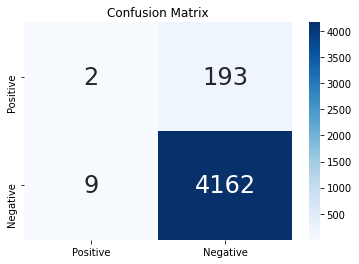

In [51]:
conf_matrix(y_test, xgb_tun_pred)

## 10.2. Cross Validation Final Model

In [52]:
# XGBoosts tuned cross validation
xgb_tuned_cv = cross_val_performance(xgb_tun, x_train, y_train)
xgb_tuned_cv

,test_Accuracy,test_Precision,test_Recall,test_F1,test_ROC
0,0.9763+/-0.1356,0.9692+/-0.1907,0.9965+/-0.0045,0.9802+/-0.1112,0.9763+/-0.1356


# 11.0. Business Performance

## 11.1. Results

In [58]:
performance_fi = pd.concat([performance, xgb_tuned_performance])
performance_fi

,Accuracy,Precision,Recall,F1,ROC
Baseline,0.044663,0.000000,0.000000,0.000000,0.500000
K-Neighbors,0.791113,0.961223,0.814193,0.881620,0.555815
Random Forest,0.943885,0.955664,0.987053,0.971105,0.503783
XGBoost Classifier,0.953733,0.955683,0.997842,0.976308,0.504049
XGBoost Classifier +,0.953733,0.955683,0.997842,0.976308,0.504049


## 11.2. Real Results

In [59]:
index = ['Logistic Regression', 'Random Forest Classifier', 'XGBoost Classifier', 'XGBoost Classifier +']

performance_final_cv = pd.concat([performance_cv, xgb_tuned_cv])
performance_final_cv.index = index
performance_final_cv

,test_Accuracy,test_Precision,test_Recall,test_F1,test_ROC
Logistic Regression,0.9008+/-0.0089,0.9845+/-0.0081,0.8144+/-0.0162,0.8914+/-0.0104,0.9008+/-0.0089
Random Forest Classifier,0.9774+/-0.0869,0.9749+/-0.1389,0.9861+/-0.0067,0.9792+/-0.0756,0.9774+/-0.0869
XGBoost Classifier,0.9763+/-0.1356,0.9692+/-0.1907,0.9965+/-0.0045,0.9802+/-0.1112,0.9763+/-0.1356
XGBoost Classifier +,0.9763+/-0.1356,0.9692+/-0.1907,0.9965+/-0.0045,0.9802+/-0.1112,0.9763+/-0.1356
